# Stationary state solutions

- $I_0 = 5$ and $N = 1000$

- Set integer levels of k^{*} in the contour plot 

- Choose 3 regimes of beta1, beta2 value pairs

- Such that k^{*} = .25, .5, .75 * N

- Add these points to the contour plot 
```python
    plt.plot(point_a[0], point_regime_low[1], 'ro')
    plt.plot(point_b[0], point_regime_mid[1], 'ro')
    plt.plot(point_b[0], point_regime_high[1], 'ro')
```


In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import pickle
import sys

In [2]:
sys.path.append("../src/")
from solve_kolmogorov import *

In [3]:
# setup
g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 5

time_max = 10

# beta1 = 2 / N       # pairwise infection rate
# beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max}\n")

Setup: 

	H = Complete Hypergraph, N = 100, I0 = 5, time_max = 10



## Pairs of beta1, beta2 values

In [4]:
beta_regimes = (int(0.25 * N), int(0.5 * N), int(0.75 * N))
beta_regimes

(25, 50, 75)

In [5]:
# define a mesh (beta1, beta2) values
# scale it later
beta1_steps, beta2_steps = 10, 30

beta1_span = (1, 8)
beta2_span = (1, 16)

np.array(beta1_span) / N, np.array(beta2_span) / (N**2)

(array([0.01, 0.08]), array([0.0001, 0.0016]))

In [6]:
beta1_vec = np.linspace(beta1_span[0], beta1_span[1], beta1_steps)
beta2_vec = np.linspace(beta2_span[0], beta2_span[1], beta2_steps)
print(f"beta1_vec = {beta1_vec}\n")
print(f"beta2_vec = {beta2_vec}")

beta1_vec = [1.         1.77777778 2.55555556 3.33333333 4.11111111 4.88888889
 5.66666667 6.44444444 7.22222222 8.        ]

beta2_vec = [ 1.          1.51724138  2.03448276  2.55172414  3.06896552  3.5862069
  4.10344828  4.62068966  5.13793103  5.65517241  6.17241379  6.68965517
  7.20689655  7.72413793  8.24137931  8.75862069  9.27586207  9.79310345
 10.31034483 10.82758621 11.34482759 11.86206897 12.37931034 12.89655172
 13.4137931  13.93103448 14.44827586 14.96551724 15.48275862 16.        ]


In [7]:
# scale it
beta1_vec = beta1_vec / N
beta2_vec = beta2_vec / (N**2)

print(f"beta1_vec = {beta1_vec}\n")
print(f"beta2_vec = {beta2_vec}")

beta1_vec = [0.01       0.01777778 0.02555556 0.03333333 0.04111111 0.04888889
 0.05666667 0.06444444 0.07222222 0.08      ]

beta2_vec = [0.0001     0.00015172 0.00020345 0.00025517 0.0003069  0.00035862
 0.00041034 0.00046207 0.00051379 0.00056552 0.00061724 0.00066897
 0.00072069 0.00077241 0.00082414 0.00087586 0.00092759 0.00097931
 0.00103103 0.00108276 0.00113448 0.00118621 0.00123793 0.00128966
 0.00134138 0.0013931  0.00144483 0.00149655 0.00154828 0.0016    ]


## Stationary / steady states $k^* = E[X(t_{max})]$

In [8]:
k_star = np.zeros((beta1_steps, beta2_steps)) # to store the values k^* = E[X(t_max)]

In [9]:
M = N + 1 # number of all states

all_states = list_all_states(g)
M, len(all_states)

(101, 101)

In [10]:
# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)

p0 = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [14]:
# TODO: this needs to be optimized also

In [11]:
solve_for_betas = True
# save solutions to run it once
file_path = f"../results/KE_solutions_G={g_type}_N={N}_I0={I0}.pickle"

if solve_for_betas:
    solutions = {}
    for i, beta1 in enumerate(beta1_vec):
        for j, beta2 in enumerate(beta2_vec):
            ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)

            def f_ode(t, p):
                return ode_system_complete(t, p)

            sol = solve_ivp(f_ode, 
                            t_span, 
                            p0, 
                            t_eval=t_eval,
                            method="LSODA"
            )
            solutions[str((i, j))] = sol
    # save the solutions
    with open(file_path, "wb") as f:
        pickle.dump(solutions, f)
else:
    # load solutions
    with open(file_path, "rb") as f:
        solutions = pickle.load(f)

# Calculate expected values and steady states

$
E[ X(t) ] \qquad \text{ and } \qquad k^{*} = E[ X(t_{max}) ]
$

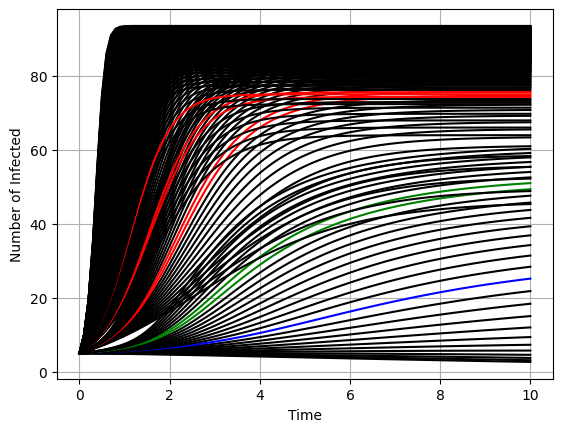

In [12]:
eps = 1
beta_indices = {0: [], 1: [], 2: []}

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):
        sol = solutions[str((i, j))]
        expected_values = calculate_expected_values(sol)
        k_star_value = expected_values[-1]
        k_star[i, j] = k_star_value

        if np.abs( k_star_value - beta_regimes[0] ) < eps:
            beta_indices[0].append((i, j))
            plt_color = "blue"
        elif np.abs( k_star_value - beta_regimes[1] ) < eps:
            beta_indices[1].append((i, j))
            plt_color = "green"
        elif np.abs( k_star_value - beta_regimes[2] ) < eps:
            beta_indices[2].append((i, j))
            plt_color = "red"
        else:
            plt_color = "k"
        
        plt.plot(sol.t, expected_values, color=plt_color)

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.savefig(f"../figures/solutions-kolmogorov/complete/KE_solutions_G={g_type}_N={N}_I0={I0}.pdf", 
            format="pdf", bbox_inches="tight")
plt.show()

In [13]:
print(f"\t (i, j): \t\t beta1 * N \t beta2 * N^2 \t k_star")
for r in [0, 1, 2]:
    print(f"\n regime k_star = {beta_regimes[r]}:")
    for (i, j) in beta_indices[r]:
        print(f"\t {(i, j)}:", end="")
        print(f"\t\t {np.round(beta1_vec[i]* N, 3)}", end="")
        print(f"\t\t {np.round(beta2_vec[j]* (N**2), 3)}", end="")
        print(f"\t\t {np.round(k_star[i, j], 5)}")

	 (i, j): 		 beta1 * N 	 beta2 * N^2 	 k_star

 regime k_star = 25:
	 (0, 11):		 1.0		 6.69		 25.14573

 regime k_star = 50:
	 (0, 21):		 1.0		 11.862		 49.29676
	 (0, 22):		 1.0		 12.379		 50.94202

 regime k_star = 75:
	 (1, 13):		 1.778		 7.724		 74.57814
	 (1, 14):		 1.778		 8.241		 75.65481
	 (2, 6):		 2.556		 4.103		 74.22358
	 (2, 7):		 2.556		 4.621		 75.50451
	 (3, 2):		 3.333		 2.034		 74.9273


In [14]:
beta_indices_selected = [(1, 3), 
                         (2, 14), 
                         (6, 24)]

betas_unscaled_selected = [(1.778, 2.552), 
                           (2.556, 8.241), 
                           (5.667, 13.414)]

In [15]:
# set levels
int(k_star.min()), int(k_star.max())

(2, 93)

In [16]:
# nlevels = 20
# levels = np.linspace(k_star.min(), k_star.max(), nlevels)
# levels = list(range(0, 85, 5))
levels = [0, 10, 25, 40, 50, 55, 60, 65, 70, 75, 80]

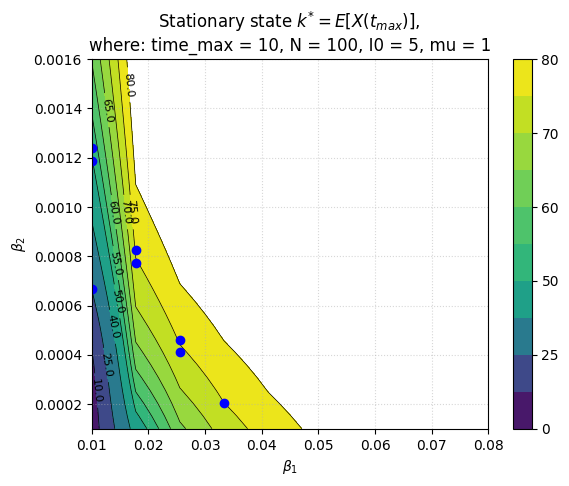

In [18]:
B1, B2 = np.meshgrid(beta1_vec, beta2_vec)

plt.figure()

contourf_plot = plt.contourf(B1, B2, k_star.T, levels=levels, cmap="viridis") # use k_star.T!!
contour_plot = plt.contour(B1, B2, k_star.T, levels=contourf_plot.levels, colors="k", linewidths=0.5)

plt.clabel(contour_plot, inline=True, fontsize=8, fmt="%.1f")
cbar = plt.colorbar(contourf_plot)
cbar.set_label(r"")

# add beta pairs from all regimes
for r in range(len(beta_regimes)):
    for (i, j) in beta_indices[r]:
        plt.plot(beta1_vec[i], beta2_vec[j], 'bo')

# for (b1N, b2NN) in betas_unscaled_selected:
#     plt.plot(b1N / N, b2NN / (N**2), 'ro')

plt_title = r"Stationary state $k^{*} = E[X(t_{max})]$, "
plt_title += f"\nwhere: time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}"
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.title(plt_title)
plt.grid(True, linestyle=":", alpha=0.5)
plt.savefig(f"../figures/solutions-kolmogorov/complete/contour_KE_solutions_G={g_type}_N={N}_I0={I0}.pdf", 
            format="pdf", bbox_inches="tight")
plt.show()

In [18]:
betas_unscaled_selected

[(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]

## Find pairs (beta1, beta2)

## Time evolution
Checking slopes

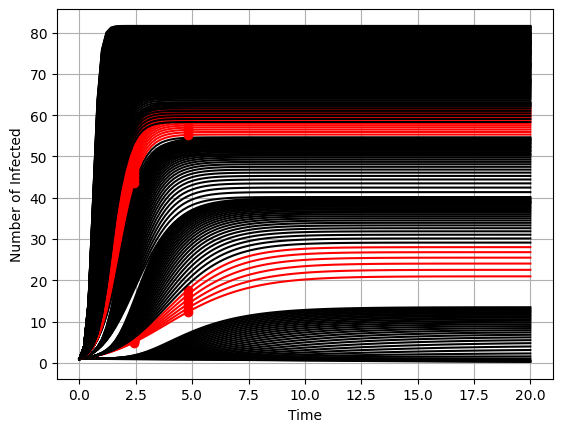

In [19]:
# plot expected values of p_{k}(t) over time t
# if slope in some range, color it 
eps_span = (0.5, 1)

# save the (beta1, beta2) pairs indices
# beta_indices = []

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):
        sol = solutions[str((i, j))]
        expected_values = calculate_expected_values(sol)
                
        # if slope < -eps, color it 
        # save the bad (beta1, beta2) pair     
        step_diff = int(nsteps / 8)
        point_a = (sol.t[2 * step_diff], expected_values[2 * step_diff])
        point_b = (sol.t[step_diff], expected_values[step_diff])

        finite_diff = (point_a[1] - point_b[1]) / step_diff
        if finite_diff > eps_span[0] and finite_diff < eps_span[1]:
            # beta_indices.append((i, j))
            plt.plot(point_a[0], point_a[1], 'ro')
            plt.plot(point_b[0], point_b[1], 'ro')
            plt.plot(sol.t, expected_values, color="red")
        else:
            plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.show()
